In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import numpy as np
from dask.diagnostics import ProgressBar
import xarray as xr
import xhistogram
import xgcm
import xbudget
from xgcm import Grid
import matplotlib.pyplot as plt

In [3]:
print(
    'numpy version', np.__version__,
    '\nxarray version', xr.__version__,
    '\nxhistogram version', xhistogram.__version__,
    '\nxgcm version', xgcm.__version__,
    '\nxbudget version', xbudget.__version__
)

numpy version 2.2.6 
xarray version 2025.8.0 
xhistogram version 0.3.2 
xgcm version 0.9.0 
xbudget version 0.5.0


## Surface water mass transformations from surface fluxes and surface $\lambda$ only

In [4]:
import xwmt
print('xwmt version', xwmt.__version__)

xwmt version 0.1.0


Suppose no interior information is available, as in the dataset loaded below that only include surface temperature, surface salinity, and surface fluxes of heat, salt, and freshwater.

In [5]:
from load_example_model_grid import load_MOM6_surface_diagnostics
grid = load_MOM6_surface_diagnostics()
ds = grid._ds

File 'MOM6_global_example_surface_fluxes_v0_0_7.nc' already exists at ../data/MOM6_global_example_surface_fluxes_v0_0_7.nc. Skipping download.


In [6]:
xbudget_dict = xbudget.load_preset_budget(model="MOM6_surface")

xbudget.collect_budgets(ds, xbudget_dict)
decompose_list = ["surface_exchange_flux", "advective", "surface_ocean_flux_advective_negative_rhs"]
decomposed_budgets = xbudget.aggregate(xbudget_dict, decompose=decompose_list)

In [7]:
## Remove 3D coordinates and variables from budgets_dict and dataset
del decomposed_budgets['heat']['lambda']
del decomposed_budgets['salt']['lambda']
del decomposed_budgets['mass']['lambda']

While we can no longer evaluate the full water mass transformation budget, we can still accurately estimate all of the surface water mass transformations terms by assuming the surface fluxes converge in a surface layer and binning these tendencies in $\lambda$ space using the surface $\lambda$ values.

`xwmt` does this automatically when the 3D `lambda` fields are missing from the `budgets_dict` argument of `WaterMassTransformations` and when the tendencies do not depend on any vertical coordinate.

In [8]:
wmt = xwmt.WaterMassTransformations(grid, decomposed_budgets)
sorted(wmt.available_processes())

['surface_exchange_flux_advective',
 'surface_exchange_flux_evaporation',
 'surface_exchange_flux_icebergs',
 'surface_exchange_flux_nonadvective',
 'surface_exchange_flux_rain_and_ice',
 'surface_exchange_flux_rivers',
 'surface_exchange_flux_sea_ice_melt',
 'surface_exchange_flux_snow',
 'surface_exchange_flux_virtual_precip_restoring',
 'surface_ocean_flux_advective_negative_rhs',
 'surface_ocean_flux_advective_negative_rhs_evaporation',
 'surface_ocean_flux_advective_negative_rhs_icebergs',
 'surface_ocean_flux_advective_negative_rhs_rain_and_ice',
 'surface_ocean_flux_advective_negative_rhs_rivers',
 'surface_ocean_flux_advective_negative_rhs_sea_ice_melt',
 'surface_ocean_flux_advective_negative_rhs_snow',
 'surface_ocean_flux_advective_negative_rhs_virtual_precip_restoring']

In [9]:
decomposed_budgets

{'mass': {'thickness': 'thkcello',
  'lhs': {},
  'rhs': {'surface_exchange_flux_rain_and_ice': 'mass_rhs_sum_surface_exchange_flux_sum_rain_and_ice',
   'surface_exchange_flux_snow': 'mass_rhs_sum_surface_exchange_flux_sum_snow',
   'surface_exchange_flux_evaporation': 'mass_rhs_sum_surface_exchange_flux_sum_evaporation',
   'surface_exchange_flux_rivers': 'mass_rhs_sum_surface_exchange_flux_sum_rivers',
   'surface_exchange_flux_icebergs': 'mass_rhs_sum_surface_exchange_flux_sum_icebergs',
   'surface_exchange_flux_sea_ice_melt': 'mass_rhs_sum_surface_exchange_flux_sum_sea_ice_melt',
   'surface_exchange_flux_virtual_precip_restoring': 'mass_rhs_sum_surface_exchange_flux_sum_virtual_precip_restoring'}},
 'heat': {'surface_lambda': 'tos',
  'lhs': {},
  'rhs': {'surface_exchange_flux_nonadvective': 'heat_rhs_sum_surface_exchange_flux_sum_nonadvective',
   'surface_exchange_flux_advective': 'heat_rhs_sum_surface_exchange_flux_sum_advective',
   'surface_ocean_flux_advective_negative_rh

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    G = wmt.integrate_transformations("sigma2", bins=np.arange(0, 40, 0.25), sum_components=True);
    with ProgressBar():
        G.load();

[########################################] | 100% Completed | 12.31 s


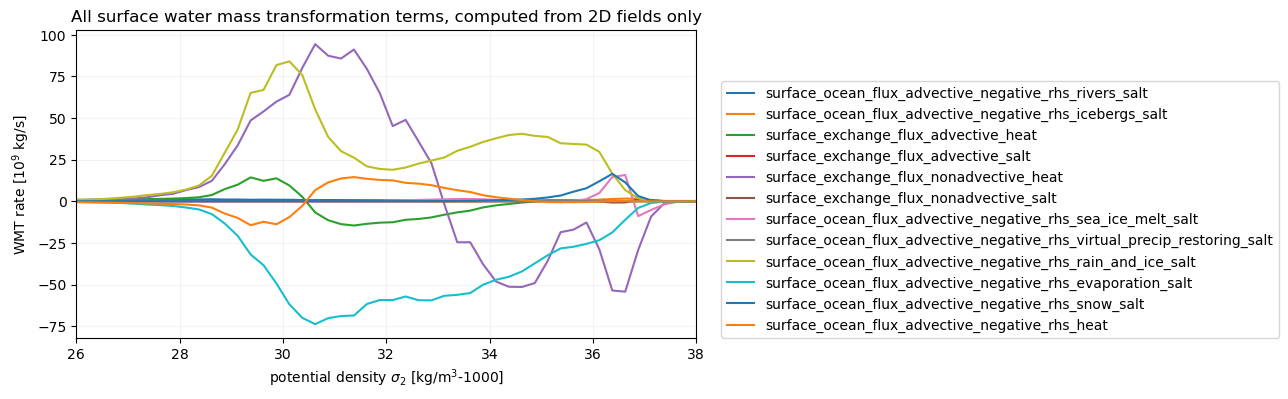

In [11]:
plt.figure(figsize=(8,4))
for v in G:
    if ("salt" not in v) and ("heat" not in v):
        continue
    (G[v]*1e-9).mean('time').plot(label=v)
plt.legend(loc=(1.04, 0))
plt.ylabel("WMT rate [$10^{9}$ kg/s]")
plt.xlabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$-1000]")
plt.grid(True, alpha=0.15)
plt.title("All surface water mass transformation terms, computed from 2D fields only");
plt.xlim(26, 38);